<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/main/Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project — Electricity Load & Renewable Forecasting

This notebook contains the full workflow for our time series forecasting project:

- Loading and preparing the OPSD dataset
- Feature engineering
- Creating sliding windows
- Building LSTM, GRU, and Transformer models
- Training and evaluating models
- Comparing performance


# Pre-Processing

In [ ]:
from google.colab import files
uploaded = files.upload()

In [2]:
import pandas as pd

df = pd.read_csv("time_series_60min_singleindex.csv")

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]
df.head()


,utc_timestamp,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
0,2014-12-31T23:00:00Z,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,41151.0,8336.0,NaN
2,2015-01-01T01:00:00Z,40135.0,8540.0,NaN
3,2015-01-01T02:00:00Z,39106.0,8552.0,NaN
4,2015-01-01T03:00:00Z,38765.0,8643.0,NaN


In [3]:
# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()

df.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,8336.0,NaN
2015-01-01 01:00:00+00:00,40135.0,8540.0,NaN
2015-01-01 02:00:00+00:00,39106.0,8552.0,NaN
2015-01-01 03:00:00+00:00,38765.0,8643.0,NaN


In [4]:
# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any NaNs that remain at the very start or end (edges)
df = df.ffill().bfill()

# Confirm everything is filled now
df.isna().sum()


,0
DE_load_actual_entsoe_transparency,0
DE_wind_onshore_generation_actual,0
DE_solar_generation_actual,0


In [5]:
# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

df.head()

,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,41151.0,8336.0,71.0,23,2,12
2015-01-01 00:00:00+00:00,41151.0,8336.0,71.0,0,3,1
2015-01-01 01:00:00+00:00,40135.0,8540.0,71.0,1,3,1
2015-01-01 02:00:00+00:00,39106.0,8552.0,71.0,2,3,1
2015-01-01 03:00:00+00:00,38765.0,8643.0,71.0,3,3,1


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler for all columns
scaler = MinMaxScaler()

# Fit and transform the DataFrame
scaled_values = scaler.fit_transform(df)

# Convert back to a DataFrame with the same index and column names
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=df.columns)

df_scaled.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,0.201226,0.264437,0.002751,1.000000,0.333333,1.0
2015-01-01 00:00:00+00:00,0.201226,0.264437,0.002751,0.000000,0.500000,0.0
2015-01-01 01:00:00+00:00,0.177815,0.271011,0.002751,0.043478,0.500000,0.0
2015-01-01 02:00:00+00:00,0.154105,0.271397,0.002751,0.086957,0.500000,0.0
2015-01-01 03:00:00+00:00,0.146248,0.274330,0.002751,0.130435,0.500000,0.0


In [7]:
import numpy as np

# We will predict this column:
target_col = "DE_load_actual_entsoe_transparency"

# How many past hours to use
window_size = 24

data = df_scaled.copy()

X_list = []
y_list = []

target_idx = data.columns.get_loc(target_col)

for i in range(len(data) - window_size):
    # past 24 hours of all features
    X_list.append(data.iloc[i : i + window_size].values)
    # load value at the next hour
    y_list.append(data.iloc[i + window_size, target_idx])

X = np.array(X_list)
y = np.array(y_list)

X.shape, y.shape


((8934, 24, 6), (8934,))

In [8]:
# Sizes
n = len(X)

train_size = int(n * 0.70)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

# Split chronologically
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y[train_size + val_size :]

X_train.shape, X_val.shape, X_test.shape


((6253, 24, 6), (1340, 24, 6), (1341, 24, 6))

/tmp/ipython-input-1379955669.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


Data Prepared. Training Shape: (35263, 24, 6)
Starting Hyperparameter Optimization...
Units: 32 | Val MAE: 0.02233
Units: 64 | Val MAE: 0.01892
Units: 128 | Val MAE: 0.02048
Optimization Complete. Best units: 64
Training best multi-variate model (64 units)...
Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0301 - mae: 0.1182 - val_loss: 0.0020 - val_mae: 0.0360 - learning_rate: 0.0010
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0053 - mae: 0.0570 - val_loss: 0.0016 - val_mae: 0.0310 - learning_rate: 0.0010
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0039 - mae: 0.0488 - val_loss: 9.9963e-04 - val_mae: 0.0243 - learning_rate: 0.0010
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0029 - mae: 0.0413 - val_loss: 8.5874e-04 - val_mae: 0.0223 - learning_rate: 0.0010
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0022 - mae: 0.0359 - val_loss: 6.2734e-04 - val_mae: 0.0194 - learning_rate: 0.0010
Epoch 6/50
551/55

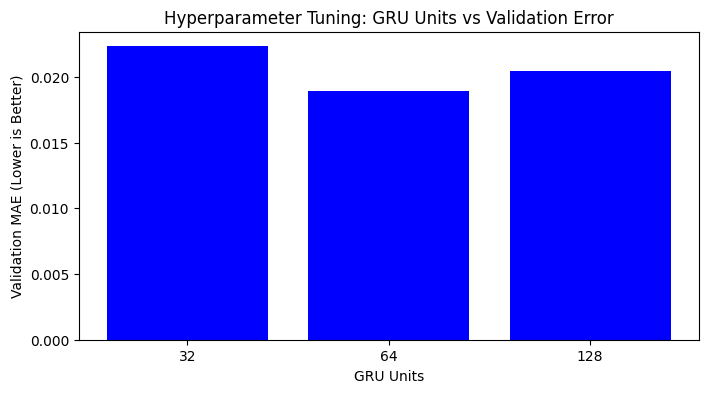

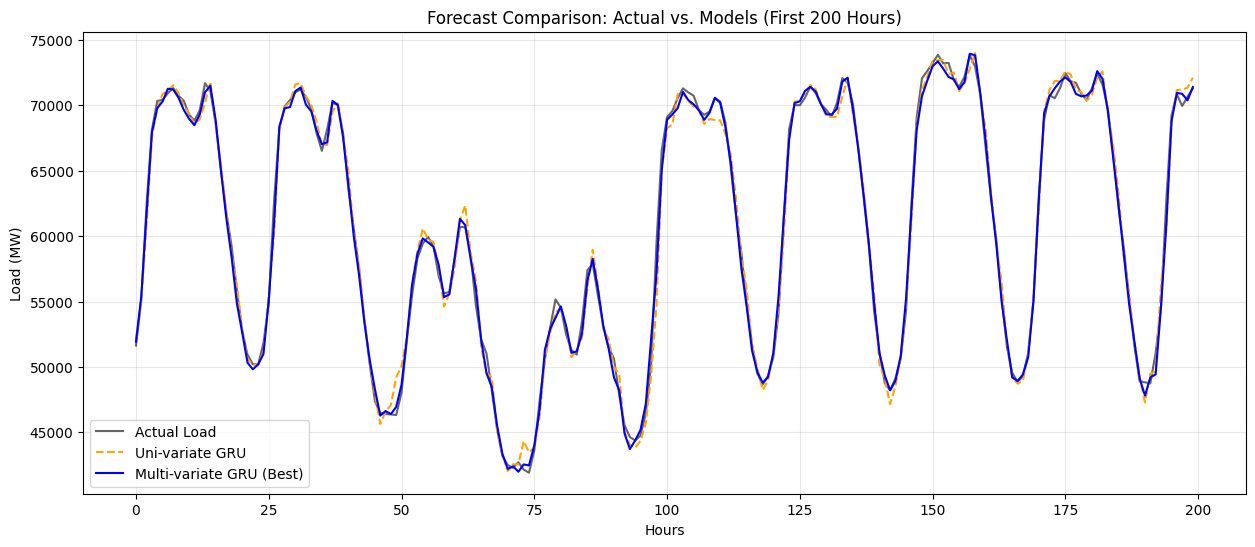

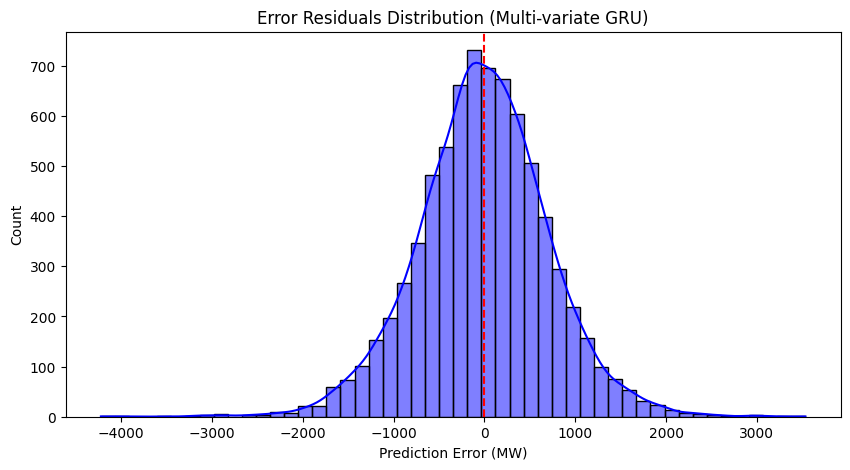

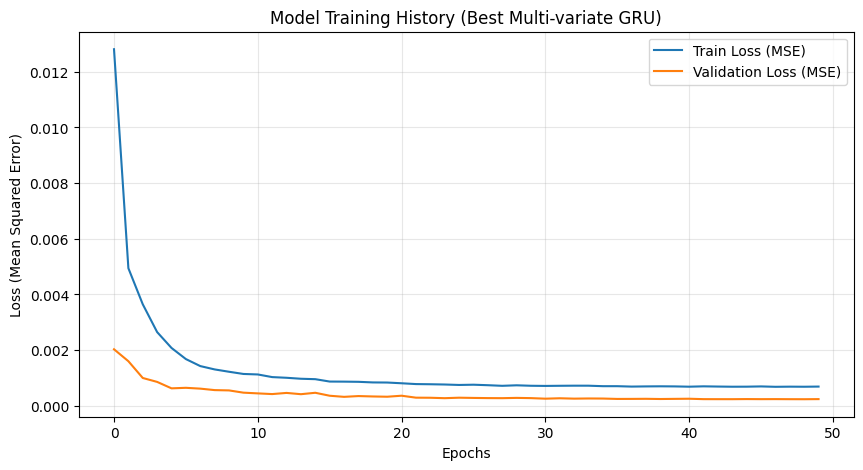

Mean Residual: -15.20 MW (Bias)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 1. Data Loading and Preprocessing
df = pd.read_csv("time_series_60min_singleindex.csv")

# Select relevant columns for Germany
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",  # Target
    "DE_wind_onshore_generation_actual",   # Exogenous
    "DE_solar_generation_actual"           # Exogenous
]
df = df[columns]

# Parse timestamps
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df = df.set_index('utc_timestamp').sort_index()

# Handle missing values
df = df.interpolate(method='time')
df = df.fillna(method='ffill').fillna(method='bfill')

# Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# 2. Scaling and Windowing
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

def create_windows(data, window_size, target_col_idx):
    """Generates sliding windows for time series data."""
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size, target_col_idx])
    return np.array(X), np.array(y)

# Configuration
WINDOW_SIZE = 24
TARGET_COL = "DE_load_actual_entsoe_transparency"
target_col_idx = df.columns.get_loc(TARGET_COL)

# Prepare Multi-variate Data
data_values = df_scaled.values
X_multi, y_multi = create_windows(data_values, WINDOW_SIZE, target_col_idx)

# Train/Validation/Test Split
n = len(X_multi)
train_split = int(n * 0.70)
val_split = int(n * 0.85)

X_train, y_train = X_multi[:train_split], y_multi[:train_split]
X_val, y_val = X_multi[train_split:val_split], y_multi[train_split:val_split]
X_test, y_test = X_multi[val_split:], y_multi[val_split:]

print(f"Data Prepared. Training Shape: {X_train.shape}")

# 3. Hyperparameter Optimization (Experiment)
def build_gru_model(input_shape, units=64, dropout=0.2):
    """Builds a GRU model with variable unit size."""
    model = Sequential([
        Input(shape=input_shape),
        GRU(units=units, return_sequences=True),
        Dropout(dropout),
        GRU(units=units // 2, return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

print("Starting Hyperparameter Optimization...")
unit_options = [32, 64, 128]
optimization_results = {}  # Dictionary to store MAE for plotting
best_mae = float('inf')
best_units = 64

for units in unit_options:
    model = build_gru_model((WINDOW_SIZE, X_train.shape[2]), units=units)

    # Fast training loop for selection
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=64,
        verbose=0
    )

    val_mae = history.history['val_mae'][-1]
    optimization_results[str(units)] = val_mae  # Save result for graph
    print(f"Units: {units} | Val MAE: {val_mae:.5f}")

    if val_mae < best_mae:
        best_mae = val_mae
        best_units = units

print(f"Optimization Complete. Best units: {best_units}")

# 4. Final Model Training
print(f"Training best multi-variate model ({best_units} units)...")

best_model = build_gru_model((WINDOW_SIZE, X_train.shape[2]), units=best_units)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

history_best = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# 5. Uni-variate Baseline (Extensiveness Check)
print("Training uni-variate baseline for comparison...")
target_data = df_scaled[[TARGET_COL]].values
X_uni, y_uni = create_windows(target_data, WINDOW_SIZE, 0)

# Split uni-variate data
X_train_u, y_train_u = X_uni[:train_split], y_uni[:train_split]
X_val_u, y_val_u = X_uni[train_split:val_split], y_uni[train_split:val_split]
X_test_u, y_test_u = X_uni[val_split:], y_uni[val_split:]

# Train Baseline
uni_model = build_gru_model((WINDOW_SIZE, 1), units=best_units)

uni_history = uni_model.fit(
    X_train_u, y_train_u,
    validation_data=(X_val_u, y_val_u),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=0
)

# 6. Evaluation and Analysis
# Generate predictions
pred_multi_scaled = best_model.predict(X_test)
pred_uni_scaled = uni_model.predict(X_test_u)

def inverse_transform_target(pred_scaled, scaler, df, target_idx):
    dummy = np.zeros((len(pred_scaled), len(df.columns)))
    dummy[:, target_idx] = pred_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, target_idx]

# Transform predictions to MW
y_test_real = inverse_transform_target(y_test.reshape(-1, 1), scaler, df, target_col_idx)
pred_multi_real = inverse_transform_target(pred_multi_scaled, scaler, df, target_col_idx)
pred_uni_real = inverse_transform_target(pred_uni_scaled, scaler, df, target_col_idx)

# Calculate metrics
mae_m = mean_absolute_error(y_test_real, pred_multi_real)
rmse_m = np.sqrt(mean_squared_error(y_test_real, pred_multi_real))
mae_u = mean_absolute_error(y_test_real, pred_uni_real)
rmse_u = np.sqrt(mean_squared_error(y_test_real, pred_uni_real))

print("\n--- FINAL RESULTS ---")
print(f"Uni-variate GRU  : MAE={mae_u:.2f} MW | RMSE={rmse_u:.2f} MW")
print(f"Multi-variate GRU: MAE={mae_m:.2f} MW | RMSE={rmse_m:.2f} MW")

improvement = ((mae_u - mae_m) / mae_u) * 100
print(f"Improvement: {improvement:.2f}%")

# 7. Visualization
# Plot 1: Optimization Results (The Visual Proof)
plt.figure(figsize=(8, 4))
plt.bar(optimization_results.keys(), optimization_results.values(), color=['blue', 'blue', 'blue'])
plt.title('Hyperparameter Tuning: GRU Units vs Validation Error')
plt.xlabel('GRU Units')
plt.ylabel('Validation MAE (Lower is Better)')
plt.show()

# Plot 2: Forecast Comparison
plt.figure(figsize=(15, 6))
slice_range = slice(0, 200) # Zoom in to first 200 hours
plt.plot(y_test_real[slice_range], label='Actual Load', color='black', alpha=0.6)
plt.plot(pred_uni_real[slice_range], label='Uni-variate GRU', color='orange', linestyle='--')
plt.plot(pred_multi_real[slice_range], label='Multi-variate GRU (Best)', color='blue')
plt.title('Forecast Comparison: Actual vs. Models (First 200 Hours)')
plt.ylabel('Load (MW)')
plt.xlabel('Hours')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 3: Residual Analysis
errors = y_test_real - pred_multi_real
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, color='blue', bins=50)
plt.title('Error Residuals Distribution (Multi-variate GRU)')
plt.xlabel('Prediction Error (MW)')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

# Plot 4: Training History (Loss Curves)
plt.figure(figsize=(10, 5))
plt.plot(history_best.history['loss'], label='Train Loss (MSE)')
plt.plot(history_best.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Training History (Best Multi-variate GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean Residual: {np.mean(errors):.2f} MW (Bias)")